In [35]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [153]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[50, 100],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise
    
    def get_bounds(self, i):
        if i == 0:
            return self.inj_limits
        elif i==1:
            return self.mid_limits
        elif i==2:
            return self.ext_limits
    
    def _rescale_output(self, output):
        """himmelblau4 returns values betwen 0 and 4899 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 4899) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._himmelblau4(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _himmelblau4(w, x, y):
        """A funky 4 dimensional parameter space with a bunch of local minima."""
        return (
            (w**2 + x + y - 11)**2 +
            (w + x**2 + y - 7)**2 +
            (w + x + y**2 - 5)**2 + 0.1 * x
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [367]:
venus = Venus(jitter=0.0)

set the currents and read the beam value

In [368]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

49.99387630128598


if currents are outside the range a `ValueError` is raised and can be captured.

In [369]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [370]:
venus._himmelblau4(6, 6, 6)

4899.6

# Bayesian Optimization

In [392]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=0.05)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  90.43    |  178.8    |  153.6    |  144.4    |
|  2        |  99.94    |  182.0    |  151.3    |  141.1    |
|  3        |  98.53    |  177.0    |  148.9    |  137.6    |
|  4        |  96.73    |  175.7    |  147.8    |  139.4    |
|  5        |  97.95    |  179.8    |  153.7    |  140.3    |
|  6        |  98.83    |  180.9    |  151.0    |  139.4    |
|  7        |  94.93    |  184.5    |  152.5    |  139.6    |
|  8        |  99.38    |  181.5    |  149.4    |  141.3    |
|  9        |  96.6     |  183.7    |  149.6    |  143.2    |
|  10       |  97.42    |  180.3    |  147.8    |  138.8    |
|  11       |  98.62    |  177.9    |  151.9    |  137.1    |
|  12       |  88.25    |  175.6    |  150.5    |  135.0    |
|  13       |  98.25    |  178.3    |  150.5    |  139.3    |
|  14       |  97.47    |  180.0    |  153.4    |  137.2    |
|  15   

In [438]:
import random
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": (175, 185), "B": (145, 155), "C": (135, 145)}
    noise = max(venus.get_noise_level(), 1e-5)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=0.05) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.scatter([182.5], [151.7], s=180, marker="*") # , [140.0]
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))    

## Simple Trial

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

Best result: {'A': 182.680694875477, 'B': 150.4628001243942, 'C': 139.37013094032363}; f(x) = 99.80494924594714.


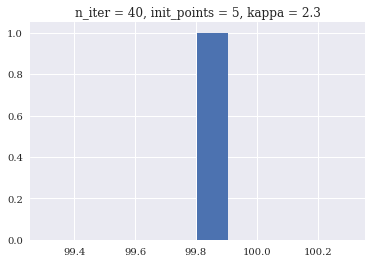

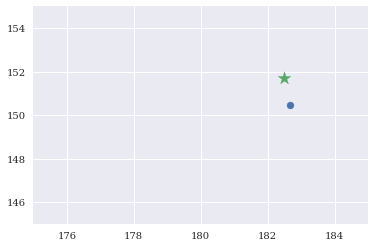

[99.80494924594714]


In [439]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


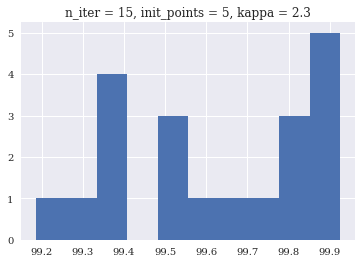

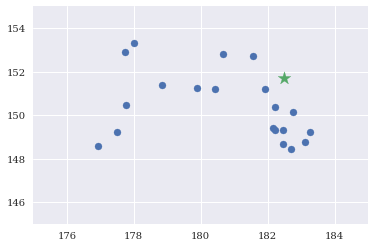

[99.9251639031329, 99.91948240495475, 99.91493055199393, 99.89657582076006, 99.87925871582044, 99.83268857799635, 99.80341410555613, 99.79976619939748, 99.72388525698813, 99.67841545795304, 99.61469553870816, 99.5491882625349, 99.49536379428616, 99.49427566300945, 99.38485022732664, 99.37416621709446, 99.36271603766814, 99.35158134404861, 99.27377753562497, 99.18572579024558]


In [440]:
trial(20, n_iter = 15, init_points = 5, kappa = 2.3, verbose = 1)

100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


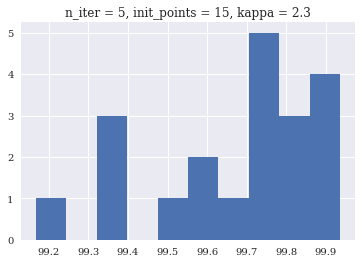

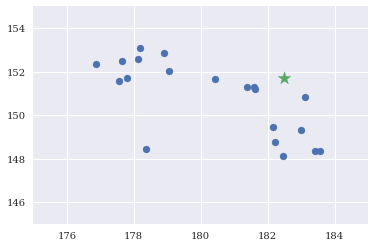

[99.93583069893484, 99.91840828486592, 99.8957793473734, 99.88244978038958, 99.82124457303632, 99.78665115181641, 99.78516681418776, 99.78083026308126, 99.76977352218367, 99.76845509145878, 99.73956270754326, 99.71480877055282, 99.66674086446241, 99.58716207249816, 99.57872577434942, 99.54036346860322, 99.36628367016917, 99.34823766077537, 99.34553764784968, 99.16728763606207]


In [441]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(20, n_iter = 5, init_points = 15, kappa = 2.3, verbose = 1)

## Trying out kappa

100%|███████████████████████████████████████████| 30/30 [01:21<00:00,  2.71s/it]


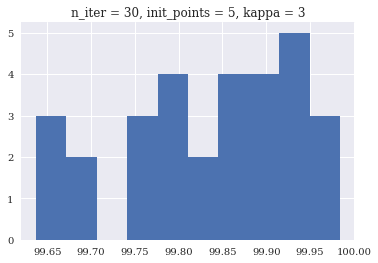

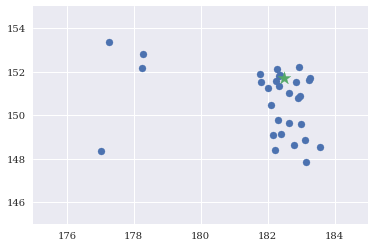

[99.984284804132, 99.97966344253695, 99.97669587737806, 99.94690246405176, 99.94476837389678, 99.94455579679024, 99.93871280656023, 99.92046212101621, 99.91431755166886, 99.90359939876625, 99.90167956623208, 99.88667172312248, 99.87407631274229, 99.86116224172869, 99.85662389886515, 99.84915484684788, 99.84046408963567, 99.82082193198261, 99.80254234455259, 99.80223277297083, 99.78558019666895, 99.78530120264652, 99.77513784845712, 99.76905104994543, 99.74122083961298, 99.69188193599062, 99.6879815917288, 99.66210639085466, 99.64668877869272, 99.636963647707]


In [442]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:21<00:00,  2.72s/it]


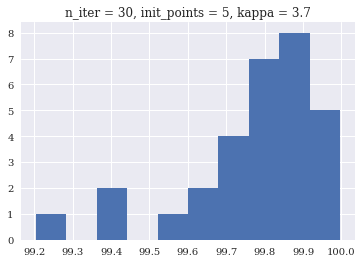

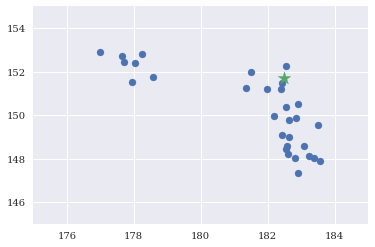

[99.99669219117439, 99.98046142557966, 99.95338808782006, 99.9497378321038, 99.94022892968061, 99.91191654005836, 99.89784412523043, 99.87726430747556, 99.87725642634595, 99.87424338568303, 99.85590545043067, 99.84513909683521, 99.8401085297003, 99.83622595591712, 99.81910961233612, 99.81718633085782, 99.8025062260954, 99.79442814729462, 99.79048153725637, 99.78169763348357, 99.75263179636931, 99.73342019122325, 99.71614763874729, 99.70416651113017, 99.66735149989307, 99.66162320061528, 99.55911733381582, 99.43228573240766, 99.42598413952186, 99.20390454170689]


In [443]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:23<00:00,  2.80s/it]


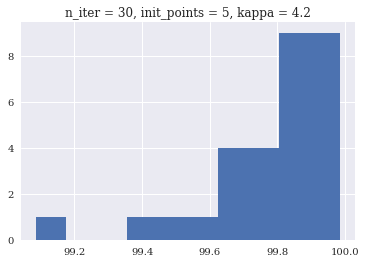

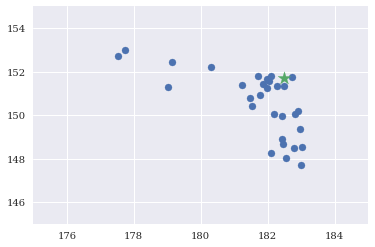

[99.98589125073553, 99.98359460890013, 99.97400826268053, 99.9349761849526, 99.931163492742, 99.92888677216844, 99.92783790744971, 99.92123089357474, 99.91056731713202, 99.89028602070854, 99.88895702788312, 99.88724886017607, 99.88483562319274, 99.88009753865396, 99.87231758732509, 99.84822711088107, 99.83954552831473, 99.8229401563635, 99.80249124284533, 99.7536036489402, 99.73210145328402, 99.72661508592765, 99.67647065926315, 99.66967684092634, 99.64146287163928, 99.62933147568091, 99.59990472626254, 99.4515910522156, 99.4123411423543, 99.08565224576522]


In [444]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:23<00:00,  2.80s/it]


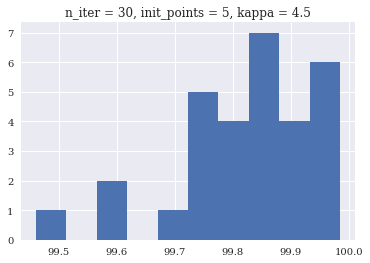

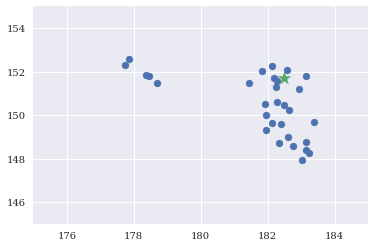

[99.98539724527453, 99.9785870256347, 99.97753658288218, 99.96004378304347, 99.94568418651349, 99.93952085069122, 99.91894479186178, 99.91594196525227, 99.90576097170401, 99.88254835502538, 99.87600555110873, 99.86726181435822, 99.86030175360085, 99.84985005047712, 99.84863490769547, 99.84655630773464, 99.83287550311442, 99.81798655947924, 99.81657084883435, 99.80555118628573, 99.77798843162897, 99.77192431550216, 99.7608878059894, 99.74979507270487, 99.74126889876075, 99.73964774707562, 99.67190981633534, 99.61026085151244, 99.59312258034063, 99.46070261183425]


In [445]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1)

## Increase n_iter

100%|███████████████████████████████████████████| 30/30 [03:23<00:00,  6.78s/it]


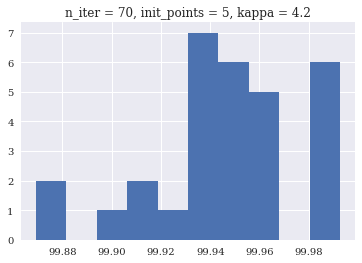

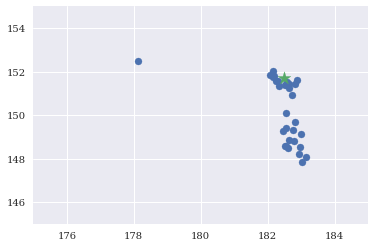

[99.99276997755527, 99.99250896521608, 99.99046794161129, 99.98698917081649, 99.98525133877303, 99.98375092529352, 99.96746393253581, 99.96251008757503, 99.96144897660076, 99.95773851899799, 99.95751684736189, 99.95115860093222, 99.9506188520256, 99.950228927782, 99.94613958226404, 99.9454230223952, 99.94358682648615, 99.94095507508477, 99.939687987474, 99.93949083047512, 99.9388493386607, 99.93815531966679, 99.93758615062332, 99.93425916771048, 99.91864245322816, 99.91791404571386, 99.91527055932444, 99.90107972443845, 99.877200828996, 99.86916687414936]


In [446]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [03:03<00:00,  6.12s/it]


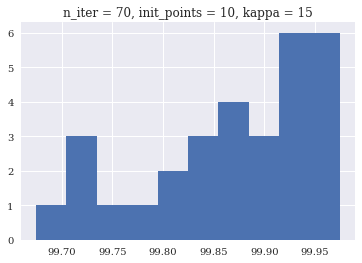

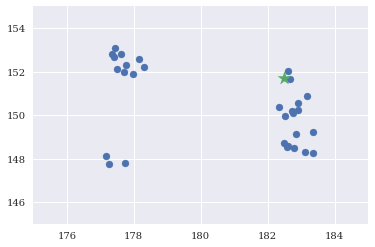

[99.9747861862077, 99.9733586088972, 99.97248254403476, 99.97064899439138, 99.96865768010954, 99.95606399017655, 99.93985770211981, 99.93976490930763, 99.93169279771104, 99.92442630435397, 99.91976991253546, 99.91938353885317, 99.90482537543328, 99.89331666749939, 99.88949505250353, 99.8846612633546, 99.88255127512882, 99.8751873779604, 99.87099206080796, 99.84132113445379, 99.83555273537135, 99.83463364745054, 99.82433112252446, 99.8006956966634, 99.77564361767244, 99.74669058837733, 99.72821232630838, 99.7265029103254, 99.72035142181939, 99.67458637960277]


In [447]:
trial(30, n_iter = 70, init_points = 10, kappa = 15, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [11:05<00:00, 22.19s/it]


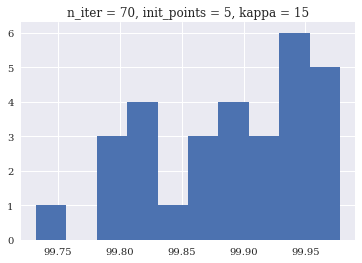

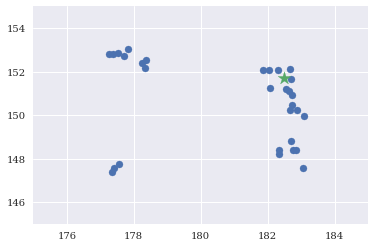

[99.97807879293973, 99.97675191923926, 99.97344470306868, 99.96999135100623, 99.9535643950013, 99.9465061202757, 99.9451044477336, 99.94119007272238, 99.94048751309435, 99.93663549585878, 99.93220976760323, 99.91632750438174, 99.91534816986376, 99.90532055657354, 99.8954611195324, 99.89006349322935, 99.88287036473898, 99.88261574667848, 99.8748784785258, 99.87451243598632, 99.85784817261, 99.83099004790381, 99.82946960570982, 99.82133645558062, 99.8211436395884, 99.81522904915198, 99.79835127685979, 99.79213291598579, 99.78942245393185, 99.73195296103913]


In [448]:
trial(30, n_iter = 70, init_points = 5, kappa = 15, verbose = 1)

In [ ]:
# TODO: guide optimization to known good points

In [65]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [66]:
# ackley_arg0((0,0,0))

In [ ]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2